In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import make_pipeline

import pickle 
from os.path import isfile

In [2]:
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py

--2022-02-20 18:58:45--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.70K  --.-KB/s    in 0s      

2022-02-20 18:58:45 (71.5 MB/s) - ‘visualization.py’ saved [13008/13008]



In [3]:
from visualization import plot_feature_importances, plot_conf_mat

In [4]:
def plot_conf(y_test, y_pred, class_names, normalize=None):
  cm = confusion_matrix(y_test, y_pred, labels=[0, 1], normalize=normalize)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot()
  plt.show()

In [5]:
path = "https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned.csv" # path for the preprocessed datadet
!wget $path

--2022-02-20 18:58:52--  https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3429217 (3.3M) [text/plain]
Saving to: ‘dataset_cleaned.csv’

dataset_cleaned.csv 100%[===================>]   3.27M  --.-KB/s    in 0.03s   

2022-02-20 18:58:52 (125 MB/s) - ‘dataset_cleaned.csv’ saved [3429217/3429217]



In [6]:
df = pd.read_csv("dataset_cleaned.csv", index_col="PROC_TRACEINFO")

In [ ]:
len(df.results) - np.sum(df.results)

34210

In [ ]:
df.head()

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,results
PROC_TRACEINFO,,,,,,,,,,,,,,
I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,12.04,12.16,-1.00,11.97,6.62,26.37,18.8,109.62,6.60,0
I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,12.12,12.19,0.39,11.97,6.41,21.03,18.5,105.48,6.40,0
I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,11.86,12.24,-1.00,11.97,6.62,25.81,17.5,100.03,6.61,0
I-B-XA1207672-190803-00051,173.5,159.56,151.8,113.25,11.82,12.35,0.39,11.97,6.62,24.62,15.6,104.94,6.61,0
I-B-XA1207672-190508-03248,174.5,172.29,177.5,112.88,12.07,12.19,-1.00,11.97,6.62,29.22,33.6,99.19,6.61,0


In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

features = list(df.columns)[:-1]

X_train = df_train[features]
X_test = df_test[features]
y_train = df_train["results"]
y_test = df_test["results"]

In [ ]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)

In [8]:
smote = SMOTE()

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
pd.value_counts(y_train_balanced)

0    27374
1    27374
Name: results, dtype: int64

In [13]:
model = RandomForestClassifier(n_estimators=100, 
                      criterion='gini', 
                      max_leaf_nodes=16, # Each tree cannot have more than that
                      random_state=0, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'auto' # auto means=sqrt(n_features)
                      )

model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(max_leaf_nodes=16, n_jobs=-1, random_state=0)

Normalized confusion matrix
[[0.82621416 0.17378584]
 [0.64179104 0.35820896]]


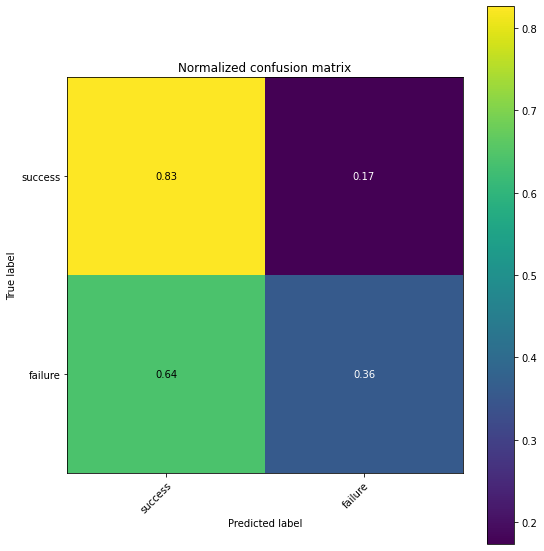

In [14]:
y_pred = model.predict(X_test)
class_names = ["success", "failure"]
np_class_names = np.array(class_names)
plot_conf_mat(y_test, y_pred, np_class_names)

Normalized confusion matrix
[[0.84113517 0.15886483]
 [0.67164179 0.32835821]]


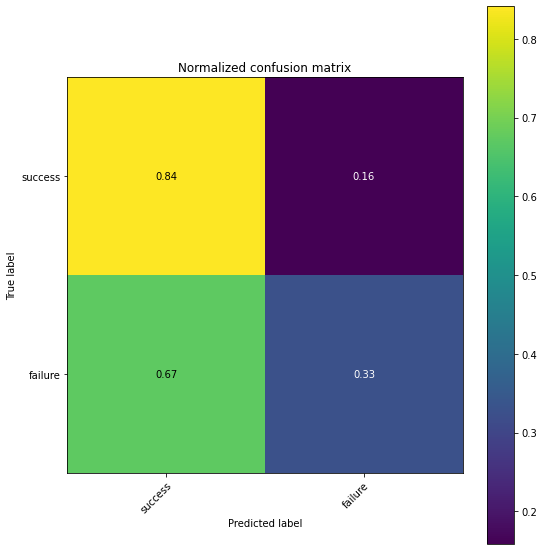

In [ ]:
y_pred = model.predict(X_test)
class_names = ["success", "failure"]
np_class_names = np.array(class_names)
plot_conf_mat(y_test, y_pred, np_class_names)

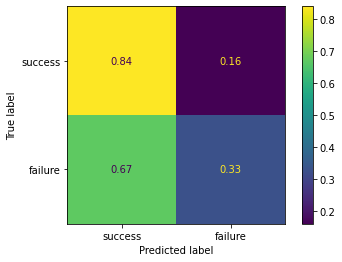

In [ ]:
plot_conf(y_test, y_pred, class_names, normalize='true')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      6836
           1       0.02      0.33      0.04        67

    accuracy                           0.84      6903
   macro avg       0.51      0.58      0.47      6903
weighted avg       0.98      0.84      0.90      6903



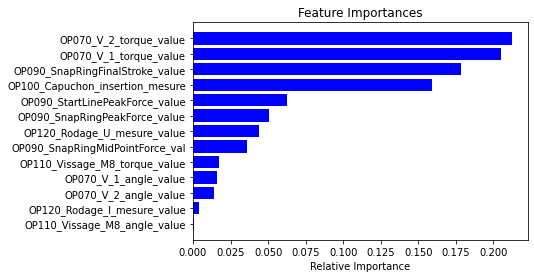

In [ ]:
plot_feature_importances(model.feature_importances_, features)

In [ ]:
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_features':list(range(1,6)),

    # Number of allowed leafs
    'max_leaf_nodes':[32, 64, 128],

    # A node will be split if this split induces a decrease of the 
    # impurity greater than or equal to this value.
    'min_impurity_decrease' : [0, 0.001, 0.01, 0.1],
            
    'max_depth':[1,10,1000,100000],

    # A node can be a leaf only if it contains at least the following fraction
    # of samples
    'min_weight_fraction_leaf' : [0.1, 0.01, 0]
    
}

In [ ]:
# Before we had used all the availble CPUs for training one random forest.
# Now, instead, we use one CPU per random forest (n_jobs=1). 
forest = RandomForestClassifier(n_estimators=100, random_state = 42, n_jobs=1,)


search = RandomizedSearchCV(
                            scoring = 'f1_macro', # See other possible metrics in
                                                # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                            
                            estimator=forest, 
                            param_distributions=param_grid,
                            n_iter=50, # We just test 50 configurations
                            verbose=10,random_state=42, 
                            n_jobs=-1, # Train forests in parallel using
                                      # all CPUs
                            cv=5 # 5-fold validation               
                          )
# Note that we are training different random forests in parallel (n_jobs=-1),
# each with a certain combination of hyper-parameters.

In [ ]:
from copy import Error
def search_or_load(model_filename, search, X_train, y_train):
  if(isfile(model_filename) ):
    print("Loading model")
    model = pickle.load(open(model_filename, 'rb'))

  else:
    print("Searching the best hyper_parameters")
    search.fit(X_train, y_train)
    print(search.best_params_)
    model = search.best_estimator_
    print("Training model")
    model.fit(X_train,y_train)
    pickle.dump(model, open(model_filename, 'wb'))
    print("Model saved in in file ", model_filename)
  return model

def load(model_filename, search, X_train, y_train):
  if(isfile(model_filename) ):
    print("Loading model")
    model = pickle.load(open(model_filename, 'rb'))
    return model
  else:
    raise Error("File is not here.")

In [ ]:
filename = "forest-f1_macro-withoutnan.pkl"
model = search_or_load(filename, search, X_train_balanced, y_train_balanced)

Searching the best hyper_parameters
Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'min_weight_fraction_leaf': 0, 'min_impurity_decrease': 0, 'max_leaf_nodes': 128, 'max_features': 5, 'max_depth': 10, 'criterion': 'gini'}
Training model
Model saved in in file  forest-f1_macro-withoutnan.pkl


In [ ]:
print(search.best_params_)

model = search.best_estimator_

{'min_weight_fraction_leaf': 0, 'min_impurity_decrease': 0, 'max_leaf_nodes': 128, 'max_features': 5, 'max_depth': 10, 'criterion': 'gini'}


In [ ]:
pickle.dump(model, open(filename, 'wb'))

In [ ]:
model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(max_depth=10, max_features=5, max_leaf_nodes=128,
                       min_impurity_decrease=0, min_weight_fraction_leaf=0,
                       n_jobs=1, random_state=42)

In [ ]:
X_test_scaled = scaler.transform(X_test)

Normalized confusion matrix
[[0.93651258 0.06348742]
 [0.85074627 0.14925373]]


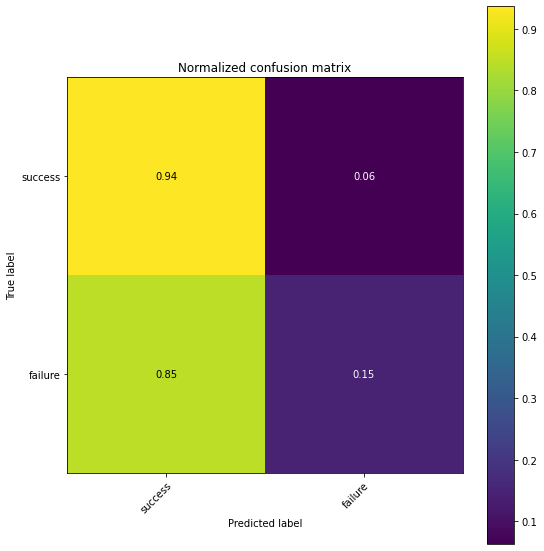

In [ ]:
y_pred = model.predict(X_test)
plot_conf_mat(y_test, y_pred, np_class_names)

In [ ]:
accuracy_score(y_test, y_pred)

0.9288715051426916

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      6836
           1       0.02      0.15      0.04        67

    accuracy                           0.93      6903
   macro avg       0.51      0.54      0.50      6903
weighted avg       0.98      0.93      0.95      6903



In [ ]:
from sklearn.compose import make_column_transformer
from xgboost import XGBClassifier

model = XGBClassifier(booster='gbtree')

In [ ]:
model.fit(X_train_balanced, y_train_balanced)

XGBClassifier()

In [ ]:
y_pred = model.predict(X_test)

Normalized confusion matrix
[[0.94967817 0.05032183]
 [0.88059701 0.11940299]]


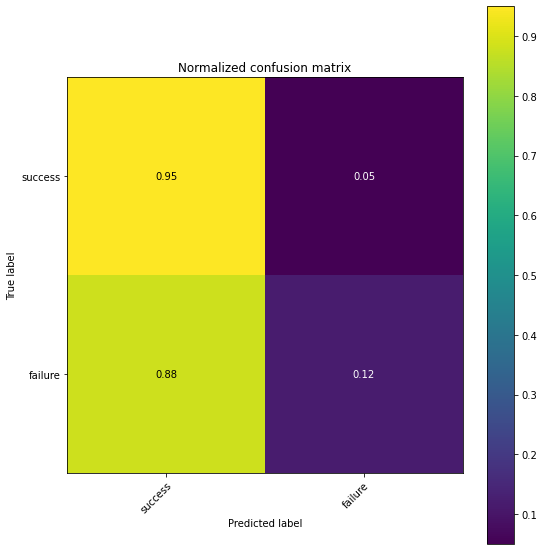

In [ ]:
plot_conf_mat(y_test, y_pred, np.array(class_names), normalize=True)